<a href="https://colab.research.google.com/github/acse-th21/README/blob/main/pre_cij_channel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import time

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras import models
from keras import layers
%matplotlib inline

from sklearn import preprocessing
import joblib
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

## Data Load

In [3]:
def read_temperature(j):
  path_name = '/content/drive/MyDrive/irp/temperature/temperature'+'_' + str(j)+'.pkl'
  data = joblib.load(path_name)
  return data

def read_Tracer(j):
  path_name = '/content/drive/MyDrive/irp/Tracer/Tracer'+'_' + str(j)+'.pkl'
  data = joblib.load(path_name)
  return data

# get temperature data of 18 sensors
Temperature_data_train = []
for i in range(1,19):
  Temperature_data_train.append(np.array(read_temperature(i)))

# get tracer data of 18 sensors
Tracer_data_train = []
for i in range(1,19):
  Tracer_data_train.append(np.array(read_Tracer(i)))

# Filling missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(Tracer_data_train)  
Tracer_data_train = imputer.transform(Tracer_data_train) 
imputer.fit(Temperature_data_train)  
Temperature_data_train=imputer.transform(Temperature_data_train)  

# reshape

Temperature_train = np.array(Temperature_data_train, dtype = np.float32)
q = Temperature_train
Temperature_data_train = Temperature_train.reshape((720,18))


Tracer_train= np.array(Tracer_data_train, dtype = np.float32)
p = Tracer_train
Tracer_data_train = Tracer_train.reshape((720,18))

path_name = '/content/drive/MyDrive/irp/observation.npy'
obs = np.load(path_name)
print(obs.shape)
rh = obs[:,1,:]
rh = np.array(rh, dtype = np.float32)
rh.shape

path_name = '/content/drive/MyDrive/irp/data.npy'
cij = np.load(path_name)
Virus_data = np.array(cij, dtype = np.float32)
print(np.shape(cij))

(720, 4, 18)
(720, 27, 27)


In [24]:
# loss plot
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_accuracy'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [5]:
def simplify_dataset(X_train, input_timestamps, step):
  X_train_simp = []
  for i in range(len(X_train) - input_timestamps*step):
    X_train_simp.append(X_train[i:i+input_timestamps*step:step])
  return np.array(X_train_simp)

In [6]:
# In groups of 9, use the first nine to predict the 10
timestamps = 10

batchsize = 128
latent_space = 100
step = 1

In [7]:
from keras.models import load_model
encode1,decode1 = load_model('/content/drive/MyDrive/irp/model/autoencoder1.h5').layers
encode2,decode2 = load_model('/content/drive/MyDrive/irp/model/autoencoder2.h5').layers
encode3,decode3 = load_model('/content/drive/MyDrive/irp/model/channel_4000.h5').layers 

In [8]:
scaler1 = joblib.load('/content/drive/MyDrive/irp/model/TE_scaled.pkl')
scaler2 = joblib.load('/content/drive/MyDrive/irp/model/TR_scaled.pkl')
scaler3 = joblib.load('/content/drive/MyDrive/irp/model/RH_scaled.pkl')
scaler4 = joblib.load('/content/drive/MyDrive/irp/model/cij_scaled.pkl')

scaler21 = joblib.load('/content/drive/MyDrive/irp/model/sensor_scaler_minmax.pkl')
scaler22 = joblib.load('/content/drive/MyDrive/irp/model/cij_output_scaled.pkl')

In [9]:
Pca = joblib.load('/content/drive/MyDrive/irp/model/pca_channel.pkl')

In [25]:
scaler1= MinMaxScaler((0,1))
scaler2= MinMaxScaler((0,1))
scaler3= MinMaxScaler((0,1))
TE_scaled = scaler1.fit_transform(Temperature_data_train)
TR_scaled = scaler2.fit_transform(Tracer_data_train)
RH_scaled = scaler3.fit_transform(rh)

cij_flat = cij.reshape(720,27*27)
cij_train_all_scaled = scaler4.transform(cij_flat)
cij = cij_flat.reshape(720,27,27)

# ev data
TE = simplify_dataset(TE_scaled, timestamps, step)
TR = simplify_dataset(TR_scaled, timestamps, step)
RH = simplify_dataset(RH_scaled, timestamps, step)

TE = TE[0].reshape(1,1,timestamps,18)
TR = TR[0].reshape(1,1,timestamps,18)
RH = RH[0].reshape(1,1,timestamps,18)

ev_test = np.concatenate((TE,TR,RH), axis = 1)


cij_train_all = simplify_dataset(cij, timestamps, step)
cij_test = cij_train_all[0].reshape(1,10,27,27)

print(ev_test.shape)
print(cij_test.shape)

(1, 3, 10, 18)
(1, 10, 27, 27)


In [26]:
pre_cij = cij_test
pre_ev = ev_test
print(pre_cij.shape,pre_ev.shape)

cij_test = cij_test[:,:-1,:,:]
ev_test = ev_test[:,:,:-1,:]


for i in range(710):
  ev_test  = np.concatenate((ev_test, ev_test[:,:,-1:,:]), axis=2)
  cij_test  = np.concatenate((cij_test, cij_test[:,-1:,:,:]), axis=1)

  encoder_sensors = encode1(ev_test)
  encoder_cij = encode2(cij_test)

  sscaler21= MinMaxScaler((0,1))
  encoder_sensors_scaled = scaler21.fit_transform(encoder_sensors)
  sscaler22= MinMaxScaler((0,1))
  encoder_cij_scaled = scaler22.fit_transform(encoder_cij)

  all_test_scaled = np.concatenate((encoder_sensors_scaled,encoder_cij_scaled), axis = 1)
  ev_test_Pca = Pca.transform(all_test_scaled)

  X_output = (ev_test_Pca.reshape((1,541,1))).astype(np.float32)

  for i in range(10):
    test_all3 = encode3(X_output,training = False)
    test_all4 = decode3(test_all3,training = False)

  test_pca_inv = Pca.inverse_transform(test_all4)

  # split
  split1 = test_pca_inv[0,:timestamps*18*96*3]
  split2 = test_pca_inv[0,timestamps*18*96*3:]

  split1 = split1.reshape(1,timestamps*18*96*3)
  split2 = split2.reshape(1,timestamps*27*27*9)

  sensor_inv = scaler21.inverse_transform(split1)
  cij_inv = scaler22.inverse_transform(split2)

  sensor_output = decode1(sensor_inv)
  cij_output = decode2(cij_inv)

  pre_cij  = np.concatenate((pre_cij, cij_output), axis=0)
  pre_ev = np.concatenate((pre_ev, sensor_output), axis=0)

  ev_test = sensor_output[:,:,1:,:]
  cij_test = cij_output[:,1:,:,:]
  

(1, 10, 27, 27) (1, 3, 10, 18)


In [256]:
print(pre_ev.shape)

(711, 3, 10, 18)


In [27]:
print(pre_cij.shape)
cij_flat = pre_cij.reshape(711*10,27*27)
cij_flat = scaler4.inverse_transform(cij_flat)
pre_cij_inv  = cij_flat.reshape(711,10,27,27)

print(pre_ev.shape)
split_TE = pre_ev[:,:1,:,:]
split_TR = pre_ev[:,1:-1,:,:]
split_RH = pre_ev[:,-1:,:,:]

split_TE = split_TE.reshape(711*10,18)
split_TR = split_TR.reshape(711*10,18)
split_RH = split_RH.reshape(711*10,18)
print(split_TE.shape,split_TR.shape,split_RH.shape)
split_TE = scaler1.inverse_transform(split_TE)
split_TR = scaler2.inverse_transform(split_TR)
split_RH = scaler3.inverse_transform(split_RH)

# get the predicted value and reshape
split_TE = split_TE.reshape(711,10,18)
split_TR = split_TR.reshape(711,10,18)
split_RH = split_RH.reshape(711,10,18)
final_TE = split_TE[1:,-1:,:]
final_TR = split_TR[1:,-1:,:]
final_RH = split_RH[1:,-1:,:]
final_TE = np.concatenate((split_TE[:1,:,:].reshape(10,1,18),final_TE), axis=0).reshape(720,18)
final_TR = np.concatenate((split_TR[:1,:,:].reshape(10,1,18),final_TR), axis=0).reshape(720,18)
final_RH = np.concatenate((split_RH[:1,:,:].reshape(10,1,18),final_RH), axis=0).reshape(720,18)

final_cij = pre_cij_inv[1:,-1:,:]
final_cij = final_cij.reshape(710,27,27)
pre_cij_inv = pre_cij_inv[:1,:,:,:].reshape(10,27,27)
final_cij = np.concatenate((pre_cij_inv,final_cij),  axis=0).reshape(720,27,27)
final_cij.shape

(711, 10, 27, 27)
(711, 3, 10, 18)
(7110, 18) (7110, 18) (7110, 18)


(720, 27, 27)

In [28]:
print(final_TE[:1,:10],Temperature_data_train[:1,:10])

[[300.      300.      299.9996  299.99057 299.96155 299.90375 299.84915
  299.80923 298.86295 296.72604]] [[300.      300.      299.9996  299.99057 299.96155 299.90375 299.84915
  299.80923 298.86295 296.72604]]


In [29]:
final_TE_plot = final_TE.T
Temperature_plot = Temperature_data_train.T
print(final_TE_plot.shape,Temperature_plot.shape)

(18, 720) (18, 720)


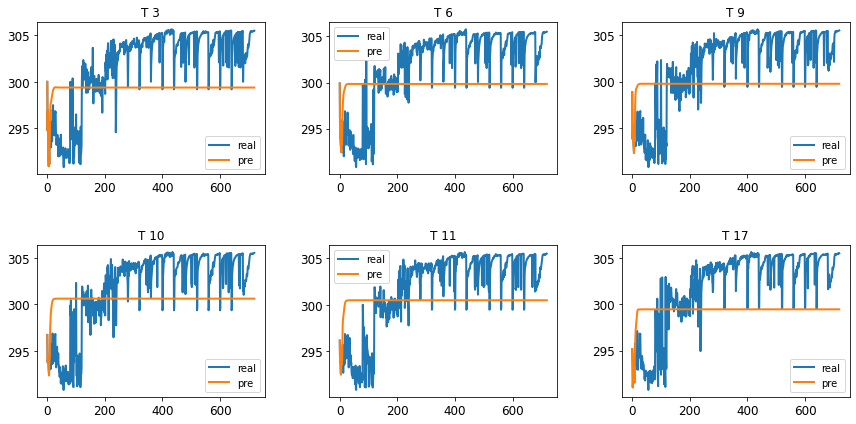

In [30]:
fig, ax = plt.subplots(2,3, figsize=[12, 6])
range_list = [2, 5, 8, 9, 10, 16]
i = 0
for number in range_list:
  fig.tight_layout(h_pad=3.5, w_pad=3.5)
  ax.flatten()[i].plot(Temperature_plot[number], ls="-", lw=2, label="real")
  fig.tight_layout(h_pad=3.5, w_pad=3.5)
  ax.flatten()[i].set_title('T '+str(int((number+1))))
  ax.flatten()[i].plot(final_TE_plot[number], ls="-", lw=2, label="pre")
  ax.flatten()[i].legend()
  i+=1

In [31]:
final_TR = final_TR.T
print(final_TR.shape,Tracer_train.shape)

(18, 720) (18, 720)


In [32]:
print(final_TR[:1,:10],Tracer_train[:1,:10])

[[0.00043    0.00043063 0.00043921 0.00044405 0.00045512 0.00047859
  0.00049523 0.00050142 0.00051241 0.00056383]] [[0.00043    0.00043    0.00043    0.00043    0.00043    0.00043001
  0.00043001 0.00043001 0.00043001 0.00043001]]


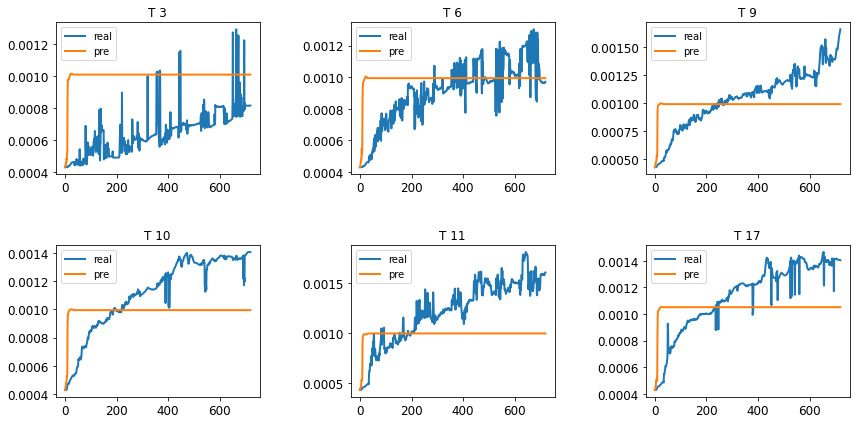

In [33]:
fig, ax = plt.subplots(2,3, figsize=[12, 6])
range_list = [2, 5, 8, 9, 10, 16]
i = 0
for number in range_list:
  fig.tight_layout(h_pad=3.5, w_pad=3.5)
  ax.flatten()[i].plot(Tracer_train[number], ls="-", lw=2, label="real")
  fig.tight_layout(h_pad=3.5, w_pad=3.5)
  ax.flatten()[i].set_title('T '+str(int((number+1))))
  ax.flatten()[i].plot(final_TR[number], ls="-", lw=2, label="pre")
  ax.flatten()[i].legend()
  i+=1

In [34]:
print(final_cij.shape)
print(Virus_data.shape)

(720, 27, 27)
(729, 720)


In [37]:
final_cij = final_cij.reshape(720,27*27).T
Virus_data = Virus_data.reshape(720,27*27).T
print(final_cij.shape)
print(Virus_data.shape)

(729, 720)
(729, 720)


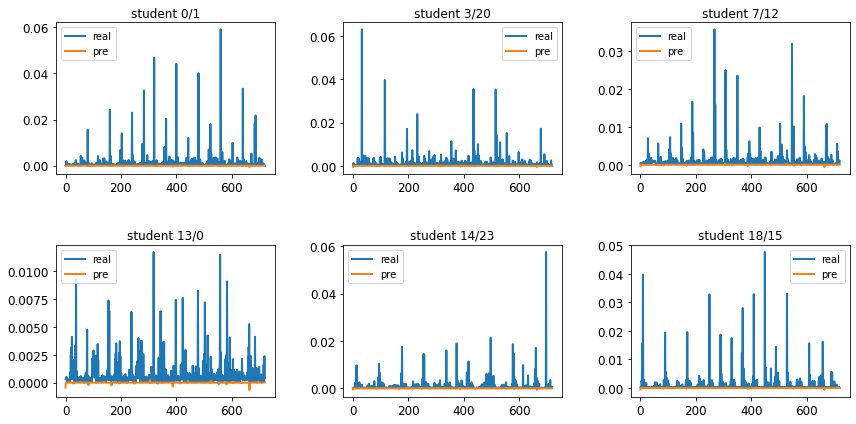

In [38]:
fig, ax = plt.subplots(2,3, figsize=[12, 6])
range_list = [0, 100, 200, 350, 400, 500]
i = 0
for number in range_list:
  fig.tight_layout(h_pad=3.5, w_pad=3.5)
  ax.flatten()[i].plot(Virus_data[number], ls="-", lw=2, label="real")
  fig.tight_layout(h_pad=3.5, w_pad=3.5)
  ax.flatten()[i].set_title('student '+str(int((number+1)/27))+"/"+str((number+1)%27))
  ax.flatten()[i].plot(final_cij[number], ls="-", lw=2, label="pre")
  ax.flatten()[i].legend()
  i+=1